# PPO: Teaching AI Without Breaking It

So we've got a reward model that can score outputs. Great! But how do we use it to improve our language model?

That's where PPO comes in. And before your eyes glaze over at another acronym, let me promise you: this is one of the most clean ideas in modern AI.

## What is PPO?

**PPO** stands for **Proximal Policy Optimization). Let's break that down:

- **Policy** = Your model's strategy for choosing outputs (what to say given some input)
- **Optimization** = Making it better (duh)
- **Proximal** = Staying close, not jumping too far

(Proximal comes from the Latin "proximus" meaning "nearest." Same root as "proximity." Who says you can't learn Latin from AI tutorials?)

Here's the core insight: **improving a neural network policy is dangerous**. Take too big a step, and your model can catastrophically forget everything it learned. It's like adjusting a recipe. add way too much salt and you've ruined dinner.

PPO solves this by keeping updates *proximal*. close to where we started. Conservative. Safe.

This is what powers ChatGPT, Claude, and every aligned language model you've ever used. It's what makes RLHF actually work in practice.

## The Problem: Why Regular Policy Gradients Break Everything

First, let's talk about what **doesn't** work: vanilla policy gradients.

A **policy gradient** is just a fancy way of saying "adjust the model based on which outputs got high rewards." The basic formula looks like this:

$$\nabla_\theta J(\theta) = \mathbb{E} \left[ \nabla_\theta \log \pi_\theta(a | s) \cdot R \right]$$

Let's decode this math:
- $\theta$ = Your model's parameters (all those billions of weights)
- $\pi_\theta(a | s)$ = Probability your model assigns to action $a$ given state $s$ (in language: probability of generating some text given a prompt)
- $R$ = Reward you got for that action
- $\nabla_\theta$ = Gradient (how to change $\theta$ to improve things)
- $\mathbb{E}$ = Expected value (average over many samples)

In plain English: "Move the model's parameters in whatever direction makes high-reward outputs more likely."

Sounds great, right?

**Wrong.**

This is *catastrophically* unstable. Why? Because neural networks are weird. A "reasonable looking" gradient step can completely change the model's behavior. One update and suddenly your helpful chatbot only speaks in haikus. Another update and it forgets how to spell.

## The PPO Solution: Clip Those Gradients

PPO's big idea is **clipping**. Don't let the policy change too much in a single update. Here's the formula:

$$L^{\text{CLIP}}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]$$

Let's decode this symbol by symbol:

**$r_t(\theta)$. The Probability Ratio**

$$r_t(\theta) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}$$

This compares your *new* policy to your *old* policy. How much more (or less) likely is the new model to generate this same output?

- $r_t = 1.0$ → No change (new and old policy identical)
- $r_t = 1.5$ → New policy is 1.5x more likely to choose this action
- $r_t = 0.5$ → New policy is half as likely

**$\hat{A}_t$. The Advantage Estimate**

This measures: "Was this action better or worse than average?"

- Positive advantage = This action was better than expected (do more of this)
- Negative advantage = This action was worse than expected (do less of this)
- Zero advantage = This action was exactly average

Think of it like golf scores. Par is your baseline. Advantage tells you how many strokes above or below par you were.

**$\epsilon$. The Clipping Threshold**

Usually set to 0.2. This is the "leash" that keeps your policy from wandering too far. The ratio $r_t$ gets clipped to the range $[0.8, 1.2]$.

**The $\min$. The Conservative Part**

We take the *minimum* of the clipped and unclipped objectives. Why? Because we're pessimists (in a good way). If the clipped version is worse, we use that. This prevents over-optimistic updates.

Put it all together: **"Improve the policy based on advantages, but don't let any single action's probability change by more than ±20%."**

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def compute_ppo_loss(
    logprobs: torch.Tensor,
    old_logprobs: torch.Tensor,
    advantages: torch.Tensor,
    clip_ratio: float = 0.2
) -> torch.Tensor:
    """
    Compute PPO clipped surrogate loss.
    
    The "surrogate" part is RL jargon for "objective we're optimizing."
    We can't optimize the true policy directly, so we optimize a surrogate.
    
    Args:
        logprobs: Log probabilities under current policy
        old_logprobs: Log probabilities under old policy (from rollout)
        advantages: Advantage estimates (how good was each action)
        clip_ratio: Clipping threshold epsilon (default 0.2)
    
    Returns:
        PPO loss (to minimize: we return negative of objective)
    """
    # Compute probability ratio r_t = π_new / π_old
    # We work in log space for numerical stability
    # exp(log(a) - log(b)) = exp(log(a/b)) = a/b
    log_ratio = logprobs - old_logprobs
    ratio = torch.exp(log_ratio)
    
    # Unclipped objective: ratio * advantage
    unclipped = ratio * advantages
    
    # Clipped objective: clip(ratio, 1-ε, 1+ε) * advantage
    clipped_ratio = torch.clamp(ratio, 1 - clip_ratio, 1 + clip_ratio)
    clipped = clipped_ratio * advantages
    
    # Take minimum (conservative update) and negate (we minimize loss)
    loss = -torch.min(unclipped, clipped).mean()
    
    return loss

# Let's see this in action with some fake data
batch_size = 16

# Simulate log probabilities (negative numbers, since probs are < 1)
logprobs = torch.randn(batch_size) - 2      # Current policy
old_logprobs = torch.randn(batch_size) - 2  # Old policy

# Simulate advantages (some positive, some negative)
advantages = torch.randn(batch_size)

loss = compute_ppo_loss(logprobs, old_logprobs, advantages)
print(f"PPO Loss: {loss.item():.4f}")
print(f"\nThis loss combines {batch_size} different actions,")
print(f"each clipped to prevent catastrophic policy changes.")

PPO Loss: -0.0413

This loss combines 16 different actions,
each clipped to prevent catastrophic policy changes.


## Visualizing the Clipped Objective

Pictures are worth a thousand equations. Let's see what that clipping actually does.

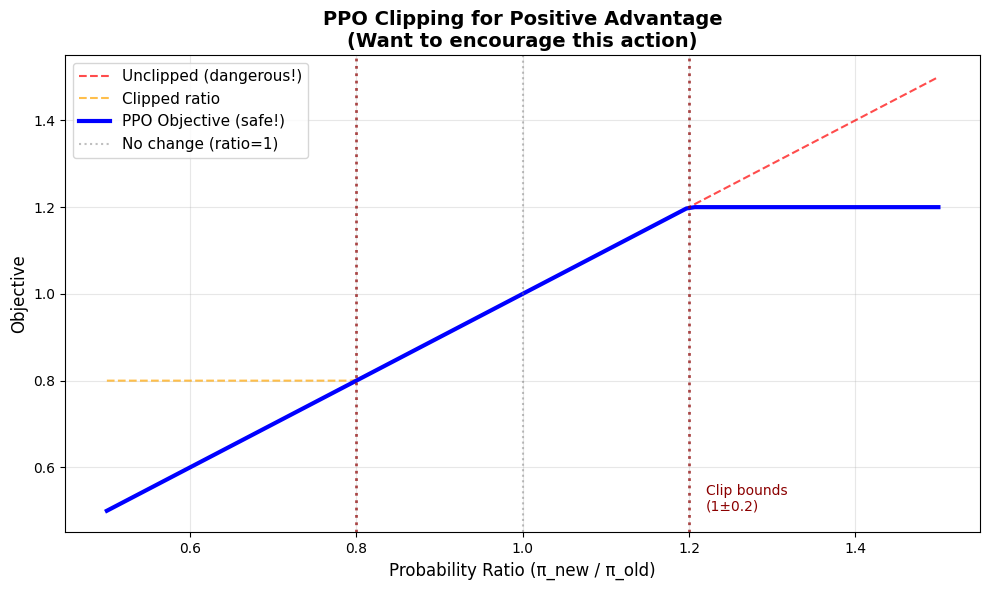

🎯 Key insight: Once ratio exceeds 1+ε, the gradient becomes ZERO!
   The objective flatlines. No incentive to change the policy further.

   This prevents overshooting. You can't accidentally make the policy
   100x more likely to take an action just because it got a good reward once.

   That's the 'proximal' in Proximal Policy Optimization.


In [2]:
# Let's visualize what happens with a positive advantage
# (i.e., we found a good action and want to do it more)

ratio = np.linspace(0.5, 1.5, 100)  # How much has the policy changed?
epsilon = 0.2                        # Our clipping threshold
advantage = 1.0                      # Positive advantage (good action!)

# Without clipping: objective = ratio * advantage
# Just a straight line: more policy change = more objective
unclipped = ratio * advantage

# With clipping: ratio gets clamped to [0.8, 1.2]
clipped_ratio = np.clip(ratio, 1 - epsilon, 1 + epsilon)
clipped = clipped_ratio * advantage

# PPO takes the minimum (conservative!)
ppo_objective = np.minimum(unclipped, clipped)

plt.figure(figsize=(10, 6))
plt.plot(ratio, unclipped, '--', label='Unclipped (dangerous!)', alpha=0.7, color='red')
plt.plot(ratio, clipped, '--', label='Clipped ratio', alpha=0.7, color='orange')
plt.plot(ratio, ppo_objective, 'b-', linewidth=3, label='PPO Objective (safe!)')

# Mark the important boundaries
plt.axvline(x=1.0, color='gray', linestyle=':', alpha=0.5, label='No change (ratio=1)')
plt.axvline(x=1-epsilon, color='darkred', linestyle=':', alpha=0.7, linewidth=2)
plt.axvline(x=1+epsilon, color='darkred', linestyle=':', alpha=0.7, linewidth=2)
plt.text(1+epsilon+0.02, 0.5, f'Clip bounds\n(1±{epsilon})', fontsize=10, color='darkred')

plt.xlabel('Probability Ratio (π_new / π_old)', fontsize=12)
plt.ylabel('Objective', fontsize=12)
plt.title('PPO Clipping for Positive Advantage\n(Want to encourage this action)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("🎯 Key insight: Once ratio exceeds 1+ε, the gradient becomes ZERO!")
print("   The objective flatlines. No incentive to change the policy further.")
print()
print("   This prevents overshooting. You can't accidentally make the policy")
print("   100x more likely to take an action just because it got a good reward once.")
print()
print("   That's the 'proximal' in Proximal Policy Optimization.")

## The Value Function: Predicting Future Rewards

PPO doesn't just optimize the policy. It also trains a **value function** to predict returns.

What's a value function?

Think of it like this: when your model starts generating a response, the value function tries to predict "how good is this going to turn out?" It's looking into the future and estimating the total reward you'll get.

The formula:

$$L^V(\theta) = \mathbb{E}_t \left[ (V_\theta(s_t) - \hat{R}_t)^2 \right]$$

Translation:
- $V_\theta(s_t)$ = Value function's prediction ("I think this will get a reward of...")
- $\hat{R}_t$ = Actual return we got ("Actually, it got a reward of...")
- $(prediction - actual)^2$ = Squared error (standard supervised learning)

Why do we need this? Two reasons:

1. **Computing advantages**: Remember $\hat{A}_t$? That's advantage = actual return - predicted value. The value function provides that baseline.

2. **Variance reduction**: Raw rewards are noisy. The value function smooths things out by learning patterns across many rollouts.

It's supervised learning buried inside reinforcement learning.

In [3]:
def compute_value_loss(
    values: torch.Tensor,
    returns: torch.Tensor,
    old_values: torch.Tensor = None,
    clip_value: bool = True,
    clip_ratio: float = 0.2
) -> torch.Tensor:
    """
    Compute value function loss (optionally clipped).
    
    Yes, we can clip the value function too! Same idea as policy clipping:
    don't let the value function change too dramatically in one update.
    
    Args:
        values: Current value predictions V_θ(s)
        returns: Actual returns R (ground truth)
        old_values: Previous value predictions (for clipping)
        clip_value: Whether to clip value updates
        clip_ratio: How much change to allow (default 0.2)
    
    Returns:
        Value function loss (MSE, possibly clipped)
    """
    if clip_value and old_values is not None:
        # Clipped value loss: similar idea to clipped policy loss
        # Don't let the value function change by more than ±clip_ratio
        value_clipped = old_values + torch.clamp(
            values - old_values, -clip_ratio, clip_ratio
        )
        
        # Compute both clipped and unclipped errors
        loss_unclipped = (values - returns) ** 2
        loss_clipped = (value_clipped - returns) ** 2
        
        # Take maximum (pessimistic again!)
        loss = torch.max(loss_unclipped, loss_clipped).mean()
    else:
        # Standard MSE (mean squared error)
        loss = F.mse_loss(values, returns)
    
    return loss

# Example with made-up data
batch_size = 16
values = torch.randn(batch_size)  # Current predictions
returns = torch.randn(batch_size)  # Actual returns
old_values = values + torch.randn(batch_size) * 0.1  # Slightly perturbed

# Compute both clipped and unclipped losses
clipped_loss = compute_value_loss(values, returns, old_values, clip_value=True)
unclipped_loss = compute_value_loss(values, returns, clip_value=False)

print(f"Value Loss (clipped):   {clipped_loss.item():.4f}")
print(f"Value Loss (unclipped): {unclipped_loss.item():.4f}")
print()
print("Clipping the value function is optional (some implementations skip it),")
print("but it can help with training stability.")

Value Loss (clipped):   1.6551
Value Loss (unclipped): 1.6551

Clipping the value function is optional (some implementations skip it),
but it can help with training stability.


## Entropy Bonus: Encouraging Exploration

Here's a problem: if you only optimize for reward, your model becomes *too* confident. It collapses to always picking its current best answer, never exploring alternatives.

This is bad! Maybe there's an even better answer it hasn't tried yet.

Solution: **entropy bonus**. Add a term that rewards the model for maintaining uncertainty.

$$H(\pi_\theta) = -\mathbb{E}_{a \sim \pi_\theta} [\log \pi_\theta(a | s)]$$

What's entropy?

In information theory, **entropy** measures uncertainty or randomness. 

- High entropy = Many possible outputs, fairly distributed (lots of exploration)
- Low entropy = One dominant output (collapsed, deterministic policy)

Imagine a language model generating the next word:
- High entropy: "The cat sat on the {mat, chair, floor, table, ...}". many options considered
- Low entropy: "The cat sat on the mat mat mat mat...". stuck in a rut

We *add* entropy to the objective (or subtract from the loss), encouraging the model to keep exploring. This prevents premature convergence to a mediocre policy.

(It's like telling a student "don't just memorize the first answer you find. keep thinking!")

In [4]:
def compute_entropy(
    logits: torch.Tensor
) -> torch.Tensor:
    """
    Compute entropy of policy distribution.
    
    Entropy = -Σ p(x) log p(x) across all possible actions x
    
    High entropy = More exploration (good early in training)
    Low entropy = More deterministic (good later in training)
    
    Args:
        logits: Raw model outputs (before softmax)
    
    Returns:
        Mean entropy across batch
    """
    # Convert logits to probabilities
    probs = F.softmax(logits, dim=-1)
    
    # Convert logits to log probabilities (numerically stable)
    log_probs = F.log_softmax(logits, dim=-1)
    
    # Entropy = -Σ p(x) log p(x)
    entropy = -(probs * log_probs).sum(dim=-1)
    
    return entropy.mean()

# Example with a vocabulary of 1000 tokens
batch_size = 16
vocab_size = 1000

# Simulate model logits (raw outputs before softmax)
logits = torch.randn(batch_size, vocab_size)

entropy = compute_entropy(logits)
print(f"Entropy: {entropy.item():.4f}")
print()

# Let's compare different entropy levels
print("Understanding entropy values:")
print()

# Very peaked distribution (low entropy)
peaked_logits = torch.randn(batch_size, vocab_size)
peaked_logits[:, 0] = 10.0  # Make first token very likely
peaked_entropy = compute_entropy(peaked_logits)
print(f"  Low entropy (peaked):  {peaked_entropy.item():.4f}: model is very confident")

# Uniform-ish distribution (high entropy)
uniform_logits = torch.randn(batch_size, vocab_size) * 0.1  # Small random values
uniform_entropy = compute_entropy(uniform_logits)
print(f"  High entropy (uniform): {uniform_entropy.item():.4f}: model is uncertain")

print()
print(f"Maximum possible entropy for {vocab_size} tokens: {np.log(vocab_size):.4f}")
print("(achieved when all tokens are equally likely)")

Entropy: 6.4207

Understanding entropy values:

  Low entropy (peaked):  0.6981: model is very confident
  High entropy (uniform): 6.9028: model is uncertain

Maximum possible entropy for 1000 tokens: 6.9078
(achieved when all tokens are equally likely)


## Putting It All Together: The Complete PPO Loss

Okay, we've got three components. Time to combine them into one mega-loss:

$$L_{\text{total}} = L^{\text{CLIP}}(\theta) + c_1 L^V(\theta) - c_2 H(\pi_\theta)$$

Where:
- $L^{\text{CLIP}}(\theta)$ = Clipped policy loss (the main event)
- $c_1 L^V(\theta)$ = Value function loss, weighted by $c_1$ (typically 0.5)
- $c_2 H(\pi_\theta)$ = Entropy bonus, weighted by $c_2$ (typically 0.01)

Notice we *subtract* the entropy (because we're minimizing loss, but want to *maximize* entropy).

The weights $c_1$ and $c_2$ balance the three objectives:
- Too much value function weight → model cares more about prediction than policy improvement
- Too much entropy weight → model stays random forever, never commits to good actions
- Too little entropy weight → model collapses to deterministic behavior too quickly

These are hyperparameters. The defaults (0.5 and 0.01) work well in practice, but you can tune them.

In [5]:
def compute_ppo_total_loss(
    policy_logprobs: torch.Tensor,
    old_logprobs: torch.Tensor,
    advantages: torch.Tensor,
    values: torch.Tensor,
    returns: torch.Tensor,
    logits: torch.Tensor,
    clip_ratio: float = 0.2,
    vf_coef: float = 0.5,
    entropy_coef: float = 0.01
) -> dict:
    """
    Compute total PPO loss combining all three components.
    
    This is the loss you actually optimize during RLHF training.
    
    Total = Policy Loss + vf_coef * Value Loss - entropy_coef * Entropy
    
    Args:
        policy_logprobs: Log probs under current policy
        old_logprobs: Log probs under old policy (from rollout)
        advantages: Advantage estimates
        values: Value function predictions
        returns: Actual returns (ground truth for value function)
        logits: Raw model outputs (for computing entropy)
        clip_ratio: PPO clipping threshold (default 0.2)
        vf_coef: Value function loss weight (default 0.5)
        entropy_coef: Entropy bonus weight (default 0.01)
    
    Returns:
        Dictionary with total loss and individual components
    """
    # 1. Clipped policy loss (the main objective)
    policy_loss = compute_ppo_loss(policy_logprobs, old_logprobs, advantages, clip_ratio)
    
    # 2. Value function loss (helps compute better advantages)
    value_loss = compute_value_loss(values, returns, clip_value=False)
    
    # 3. Entropy bonus (encourages exploration)
    entropy = compute_entropy(logits)
    
    # Combine: minimize policy loss and value loss, maximize entropy
    total_loss = policy_loss + vf_coef * value_loss - entropy_coef * entropy
    
    return {
        'total_loss': total_loss,
        'policy_loss': policy_loss,
        'value_loss': value_loss,
        'entropy': entropy
    }

# Let's compute a full PPO loss
batch_size = 16
vocab_size = 1000

# Simulate all the inputs we'd get during training
policy_logprobs = torch.randn(batch_size) - 2
old_logprobs = torch.randn(batch_size) - 2
advantages = torch.randn(batch_size)
values = torch.randn(batch_size)
returns = torch.randn(batch_size)
logits = torch.randn(batch_size, vocab_size)

# Compute total loss
losses = compute_ppo_total_loss(
    policy_logprobs, old_logprobs, advantages,
    values, returns, logits
)

print("PPO Loss Breakdown:")
print("=" * 50)
print(f"Policy Loss:      {losses['policy_loss'].item():>8.4f}")
print(f"Value Loss:       {losses['value_loss'].item():>8.4f}  (× 0.5 coef)")
print(f"Entropy:          {losses['entropy'].item():>8.4f}  (× 0.01 coef)")
print("-" * 50)
print(f"Total Loss:       {losses['total_loss'].item():>8.4f}")
print()
print("This total loss is what we backpropagate through the model.")
print("Minimize this, and your policy improves (safely!).")

PPO Loss Breakdown:
Policy Loss:        0.7585
Value Loss:         3.0044  (× 0.5 coef)
Entropy:            6.4090  (× 0.01 coef)
--------------------------------------------------
Total Loss:         2.1966

This total loss is what we backpropagate through the model.
Minimize this, and your policy improves (safely!).


## PPO Hyperparameters: The Knobs You Can Turn

Here are the key hyperparameters in PPO, and what they do:

| Parameter | Default | What it controls | Effect if too high | Effect if too low |
|-----------|---------|------------------|-------------------|------------------|
| `clip_ratio` (ε) | 0.2 | How much policy can change per update | More aggressive updates, risk of instability | Too conservative, slow learning |
| `vf_coef` (c₁) | 0.5 | Weight on value function loss | Model focuses on prediction over policy | Value function trains slowly, poor advantages |
| `entropy_coef` (c₂) | 0.01 | Weight on entropy bonus | Model stays random, never converges | Model becomes deterministic too fast, gets stuck |
| `ppo_epochs` | 4 | How many times to reuse each batch | Better sample efficiency, risk overfitting | Less sample efficiency, more data needed |
| `learning_rate` | 1e-5 | Step size for optimizer | Training instability, divergence | Slow convergence |

**General wisdom:**
- Start with the defaults. They work surprisingly well.
- If training is unstable, *lower* the clip ratio and learning rate.
- If the model gets stuck in repetitive behavior, *raise* the entropy coefficient.
- If you have limited compute, *raise* ppo_epochs to squeeze more from each batch.

(But really, the defaults are good. The PPO paper figured this out through a lot of trial and error so you don't have to.)

## What We've Learned

PPO is the workhorse of modern RLHF. Here's the story in one sentence:

**Use gradients to improve your policy, but clip them aggressively to prevent catastrophic changes.**

The key insights:
1. **Clipping** prevents policy collapse (the "proximal" part)
2. **Advantage estimates** tell us which actions are better than average
3. **Value function** predicts returns and reduces variance
4. **Entropy bonus** keeps the model exploring instead of getting stuck

This is what makes ChatGPT work. This is what makes Claude work. This is what makes every aligned language model work.

## Next Steps

PPO handles the optimization, but there's one more crucial piece: the **KL penalty**. We need to prevent the model from drifting too far from its original behavior. That's up next.